In [ ]:
# Set your dataset path
dataset_path = '/path/to/CoMoFoD_small_v2/'

# Verify the path exists and contains files
import os
if os.path.exists(dataset_path):
    print("Dataset found! Contains:", len(os.listdir(dataset_path)), "files")
else:
    print("Error: Path not found. Check your dataset path.")

Mounted at /content/drive
Dataset found! Contains: 10430 files


In [ ]:
import os

# Define directory paths
base_dir = 'dataset/'
os.makedirs(base_dir, exist_ok=True)
dirs = ["labels", "images", "masks"]

for dir_name in dirs:
    os.makedirs(os.path.join(base_dir, dir_name), exist_ok=True)
    print(f"Created directory: {os.path.join(base_dir, dir_name)}")

print("\nFolder structure ready!")

Created directory: /content/dataset/labels
Created directory: /content/dataset/images
Created directory: /content/dataset/masks

Folder structure ready!


In [ ]:
import os
import shutil
from tqdm import tqdm

# Paths
src_path = '/path/to/CoMoFoD_small_v2/'
dest_path = 'dataset/'

# Categorize files
for filename in tqdm(os.listdir(src_path)):
    src_file = os.path.join(src_path, filename)

    if '_B.' in filename:  # Label files
        shutil.copy(src_file, os.path.join(dest_path, 'labels', filename))
    elif '_M.' in filename:  # Mask files
        shutil.copy(src_file, os.path.join(dest_path, 'masks', filename))
    elif '_F_' in filename or '_O_' in filename:  # Image files
        shutil.copy(src_file, os.path.join(dest_path, 'images', filename))

# Verify counts
print("\nFile organization complete!")
print(f"Labels: {len(os.listdir(dest_path+'labels'))} files")
print(f"Images: {len(os.listdir(dest_path+'images'))} files")
print(f"Masks: {len(os.listdir(dest_path+'masks'))} files")

100%|██████████| 10430/10430 [04:11<00:00, 41.40it/s] 


File organization complete!
Labels: 200 files
Images: 9626 files
Masks: 200 files


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

def unet(input_size=(256, 256, 3)):
    # Input layer
    inputs = Input(input_size)

    # Downsample path (Contracting)
    # Block 1
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (Bottleneck)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Upsample path (Expanding)
    # Block 5
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2D(64, 2, activation='relu', padding='same')(u5)
    u5 = BatchNormalization()(u5)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Block 6
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(32, 2, activation='relu', padding='same')(u6)
    u6 = BatchNormalization()(u6)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    # Block 7 (Output)
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(16, 2, activation='relu', padding='same')(u7)
    u7 = BatchNormalization()(u7)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create model
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 485,297 (1.85 MB)

 Trainable params: 483,665 (1.85 MB)

 Non-trainable params: 1,632 (6.38 KB)

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

class DataLoader(Sequence):
    def __init__(self, image_folder, label_folder, batch_size=8, img_size=(256, 256)):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
        self.label_paths = [os.path.join(label_folder, f.split('_')[0] + '_B.png') for f in os.listdir(image_folder)]
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(self.image_paths))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.img_size, 1), dtype=np.float32)

        for i, data_idx in enumerate(batch_indices):
            # Load image
            img = cv2.imread(self.image_paths[data_idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            X[i] = img / 255.0  # Normalize

            # Load corresponding mask
            mask = cv2.imread(self.label_paths[data_idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size)
            y[i] = np.expand_dims(mask, -1) / 255.0  # Normalize

        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Initialize data loaders
train_loader = DataLoader(
    image_folder='/dataset/images',
    label_folder='/dataset/labels',
    batch_size=8
)

# Test one batch
X_batch, y_batch = train_loader[0]
print(f"Batch shape - Images: {X_batch.shape}, Masks: {y_batch.shape}")

Batch shape - Images: (8, 256, 256, 3), Masks: (8, 256, 256, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9089 - loss: 0.3315
Epoch 1: val_loss improved from inf to 0.10086, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 303s 229ms/step - accuracy: 0.9090 - loss: 0.3314 - val_accuracy: 0.9648 - val_loss: 0.1009
Epoch 2/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9774 - loss: 0.0628
Epoch 2: val_loss improved from 0.10086 to 0.04343, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 233s 193ms/step - accuracy: 0.9774 - loss: 0.0628 - val_accuracy: 0.9825 - val_loss: 0.0434
Epoch 3/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9822 - loss: 0.0424
Epoch 3: val_loss improved from 0.04343 to 0.03608, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 234s 194ms/step - accuracy: 0.9822 - loss: 0.0424 - val_accuracy: 0.9843 - val_loss: 0.0361
Epoch 4/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9843 - loss: 0.0354
Epoch 4: val_loss improved from 0.03608 to 0.03192, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 261s 194ms/step - accuracy: 0.9843 - loss: 0.0354 - val_accuracy: 0.9852 - val_loss: 0.0319
Epoch 5/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9851 - loss: 0.0326
Epoch 5: val_loss improved from 0.03192 to 0.02843, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9851 - loss: 0.0326 - val_accuracy: 0.9862 - val_loss: 0.0284
Epoch 6/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9853 - loss: 0.0313
Epoch 6: val_loss did not improve from 0.02843
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9853 - loss: 0.0313 - val_accuracy: 0.9860 - val_loss: 0.0296
Epoch 7/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9861 - loss: 0.0294
Epoch 7: val_loss did not improve from 0.02843
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 231s 192ms/step - accuracy: 0.9861 - loss: 0.0294 - val_accuracy: 0.9857 - val_loss: 0.0318
Epoch 8/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9861 - loss: 0.0287
Epoch 8: val_loss did not improve from 0.02843
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 230s 191ms/step - accuracy: 0.9861 - loss: 0.0287 - val_accuracy: 0.9861 - val_loss: 0.0298
Epoch 9/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9864 - loss: 0.0283
Epoch 9

1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9864 - loss: 0.0283 - val_accuracy: 0.9867 - val_loss: 0.0272
Epoch 10/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9867 - loss: 0.0273
Epoch 10: val_loss did not improve from 0.02724
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9867 - loss: 0.0273 - val_accuracy: 0.9865 - val_loss: 0.0284
Epoch 11/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9866 - loss: 0.0272
Epoch 11: val_loss did not improve from 0.02724
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 231s 192ms/step - accuracy: 0.9866 - loss: 0.0272 - val_accuracy: 0.9857 - val_loss: 0.0324
Epoch 12/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9866 - loss: 0.0274
Epoch 12: val_loss improved from 0.02724 to 0.02699, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 230s 191ms/step - accuracy: 0.9866 - loss: 0.0274 - val_accuracy: 0.9869 - val_loss: 0.0270
Epoch 13/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9871 - loss: 0.0261
Epoch 13: val_loss did not improve from 0.02699
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 262s 191ms/step - accuracy: 0.9871 - loss: 0.0261 - val_accuracy: 0.9867 - val_loss: 0.0274
Epoch 14/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9867 - loss: 0.0270
Epoch 14: val_loss improved from 0.02699 to 0.02570, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 231s 192ms/step - accuracy: 0.9867 - loss: 0.0270 - val_accuracy: 0.9872 - val_loss: 0.0257
Epoch 15/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9873 - loss: 0.0255
Epoch 15: val_loss did not improve from 0.02570
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 266s 221ms/step - accuracy: 0.9873 - loss: 0.0255 - val_accuracy: 0.9863 - val_loss: 0.0286
Epoch 16/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9869 - loss: 0.0266
Epoch 16: val_loss improved from 0.02570 to 0.02553, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 230s 192ms/step - accuracy: 0.9869 - loss: 0.0266 - val_accuracy: 0.9872 - val_loss: 0.0255
Epoch 17/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9878 - loss: 0.0246
Epoch 17: val_loss did not improve from 0.02553
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 230s 191ms/step - accuracy: 0.9878 - loss: 0.0246 - val_accuracy: 0.9852 - val_loss: 0.0347
Epoch 18/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9870 - loss: 0.0263
Epoch 18: val_loss improved from 0.02553 to 0.02477, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 230s 191ms/step - accuracy: 0.9870 - loss: 0.0263 - val_accuracy: 0.9873 - val_loss: 0.0248
Epoch 19/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9874 - loss: 0.0254
Epoch 19: val_loss did not improve from 0.02477
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9874 - loss: 0.0254 - val_accuracy: 0.9869 - val_loss: 0.0259
Epoch 20/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9870 - loss: 0.0260
Epoch 20: val_loss did not improve from 0.02477
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 230s 191ms/step - accuracy: 0.9870 - loss: 0.0260 - val_accuracy: 0.9873 - val_loss: 0.0249
Epoch 21/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9872 - loss: 0.0257
Epoch 21: val_loss improved from 0.02477 to 0.02471, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 192ms/step - accuracy: 0.9872 - loss: 0.0257 - val_accuracy: 0.9874 - val_loss: 0.0247
Epoch 22/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9876 - loss: 0.0248
Epoch 22: val_loss did not improve from 0.02471
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9876 - loss: 0.0248 - val_accuracy: 0.9874 - val_loss: 0.0249
Epoch 23/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9874 - loss: 0.0248
Epoch 23: val_loss did not improve from 0.02471
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 233s 193ms/step - accuracy: 0.9874 - loss: 0.0248 - val_accuracy: 0.9869 - val_loss: 0.0259
Epoch 24/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9876 - loss: 0.0246
Epoch 24: val_loss improved from 0.02471 to 0.02430, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 261s 192ms/step - accuracy: 0.9876 - loss: 0.0246 - val_accuracy: 0.9875 - val_loss: 0.0243
Epoch 25/25
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9877 - loss: 0.0243
Epoch 25: val_loss improved from 0.02430 to 0.02428, saving model to /content/drive/MyDrive/unet_comofod.h5


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 232s 193ms/step - accuracy: 0.9877 - loss: 0.0243 - val_accuracy: 0.9876 - val_loss: 0.0243


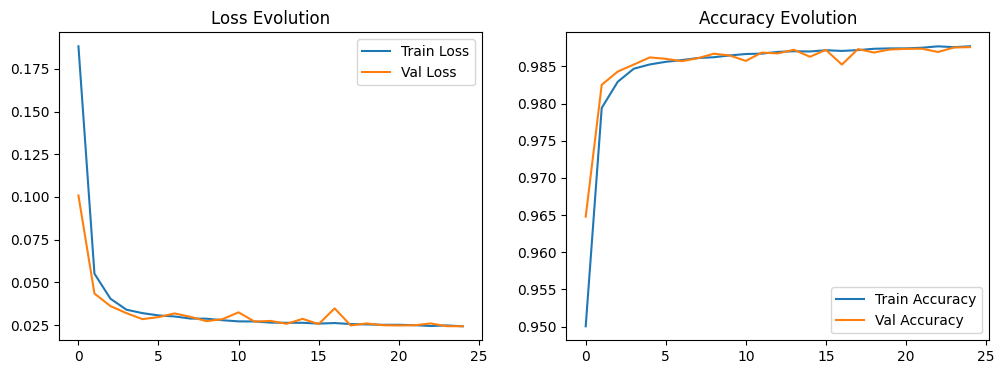

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'unet_comofod.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Split data (80% train, 20% validation)
image_files = os.listdir('/dataset/images')
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

train_loader = DataLoader(
    image_folder='/dataset/images',
    label_folder='/dataset/labels',
    batch_size=8
)

val_loader = DataLoader(
    image_folder='/dataset/images',
    label_folder='/dataset/labels',
    batch_size=8
)

# Train the model
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=25,
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


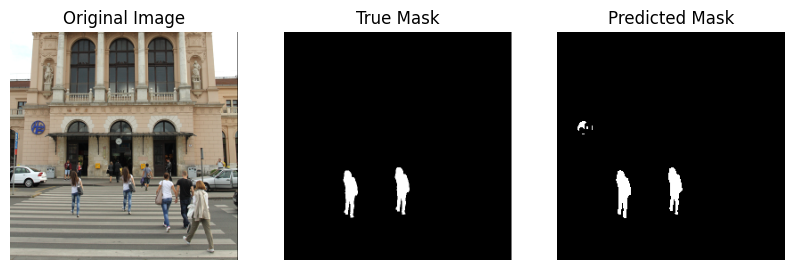

In [ ]:
# Load the best saved model (just to be safe)
best_model = tf.keras.models.load_model('unet_comofod.h5')

# Test prediction on a sample image
test_img_path = '/dataset/images/001_F_BC1.png'  # Change this to your test image path
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (256, 256))
test_img_normalized = test_img / 255.0
test_img_input = np.expand_dims(test_img_normalized, axis=0)

# Make prediction
prediction = best_model.predict(test_img_input)
prediction_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Threshold at 0.5

# Visualize results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
true_mask = cv2.imread('/dataset/labels/001_B.png', cv2.IMREAD_GRAYSCALE)
true_mask = cv2.resize(true_mask, (256, 256))
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [ ]:
# Save the complete model (architecture + weights + optimizer state)
best_model.save('unet_comofod_complete.keras')

# Also save as HDF5 for compatibility
best_model.save('unet_comofod_complete.h5')

# Download to your local machine
from google.colab import files
files.download('unet_comofod_complete.h5')

print("Model saved in two formats:")
print("1. Native Keras format (.keras)")
print("2. HDF5 format (.h5 file)")
print("The HDF5 file is being downloaded to your computer now")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved in two formats:
1. TF SavedModel format (folder)
2. HDF5 format (.h5 file)
The HDF5 file is being downloaded to your computer now
